In [2]:
# Setup

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import warnings
from matplotlib.patches import Circle, ConnectionPatch
import matplotlib.animation as animation

from utils.plot.utils import plot_cobweb, get_iterative_map_results, plot_orbit_diagram

plt.rcParams["figure.figsize"] = (20, 20)

def saveFig(filename, chapter):
  plt.savefig(f"plots/chapter{chapter}/{filename}.png", facecolor="w")

# Chapter 10 - One-Dimensional Maps

An **iterative map** has the form $x_{n + 1} = f(x_n)$, both the equation (sometimes called a **difference equation**) and the function are often referred to as **maps**. A point $x^*$ such that $f(x^*) = x^*$ is called a fixed point and can be either stable or unstable as with continuous differential equations. Maps can be analysed through **cobweb diagrams**

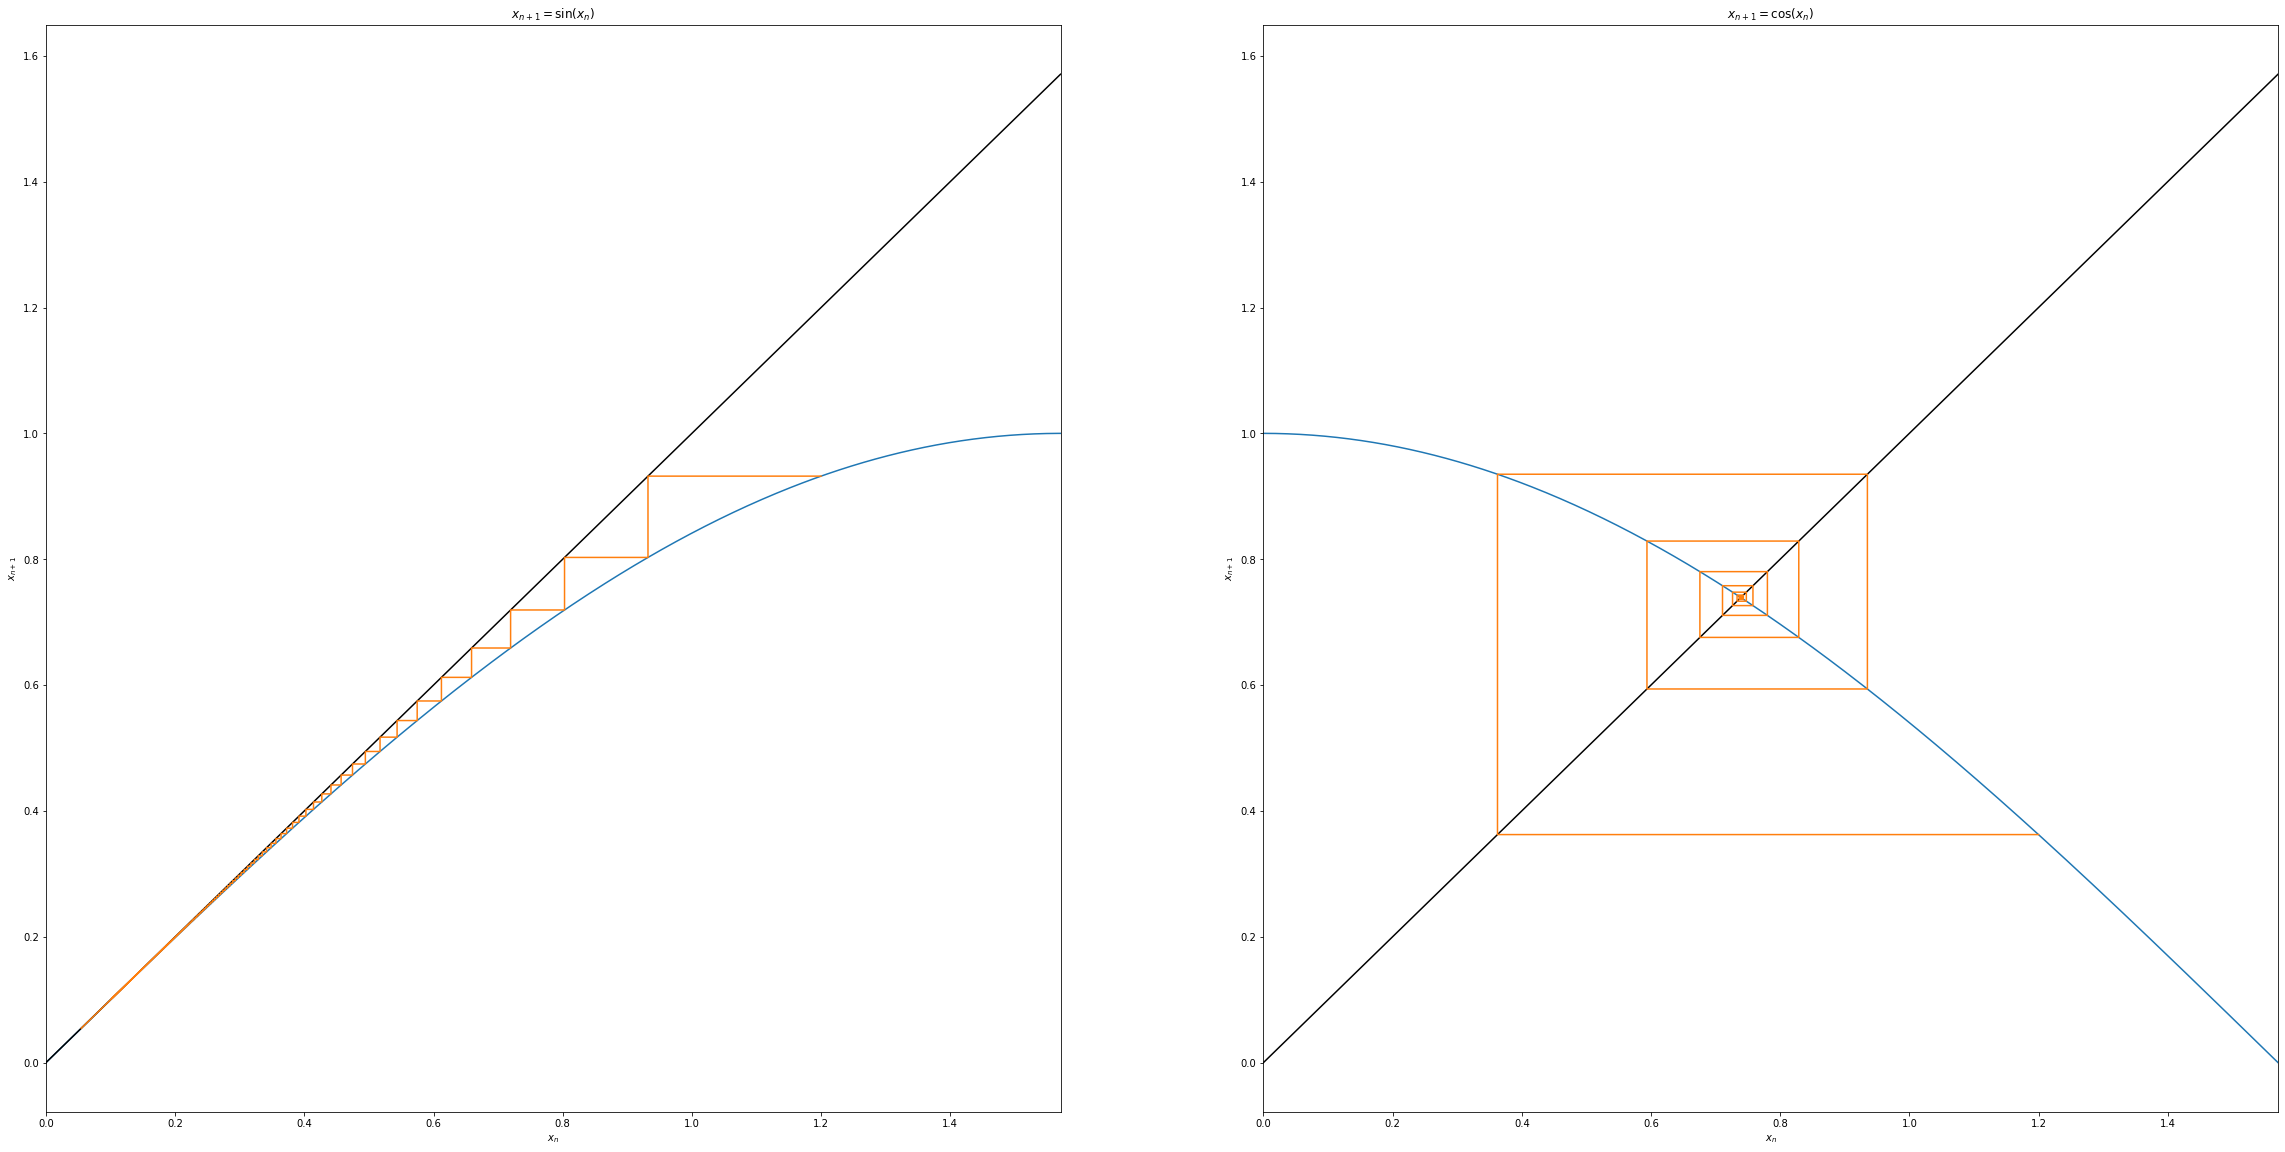

In [2]:
plt.figure(figsize=(40, 20))

plt.subplot(1, 2, 1)
plt.title("$x_{n+1} = \sin(x_n)$")
plt.xlabel("$x_n$")
plt.ylabel("$x_{n + 1}$")
plot_cobweb(lambda x: np.sin(x), [1.2], num_iterations=1000, x_range=[0, np.pi / 2])

plt.subplot(1, 2, 2)
plt.title("$x_{n+1} = \cos(x_n)$")
plt.xlabel("$x_n$")
plt.ylabel("$x_{n + 1}$")
plot_cobweb(lambda x: np.cos(x), [1.2], num_iterations=1000, x_range=[0, np.pi / 2])

## Logistic Map

The logistic map $x_{n + 1} = rx(1-x)$ with $r > 0$ (the discrete analog of the logistic function) displays chaotic behaviour for $3.4 < r < 4$. This can be analysed through an **orbit diagram** which involves plotting the values that the function takes for each value of $r$. For $3 < r < 3.4$ the points bounce back and forth between two points (after they settle down), this is called a **period-2 cycle**, as $r$ increases this then becomes period-4, then period-8..., eventually the period becomes infinite and chaotic motion occurs

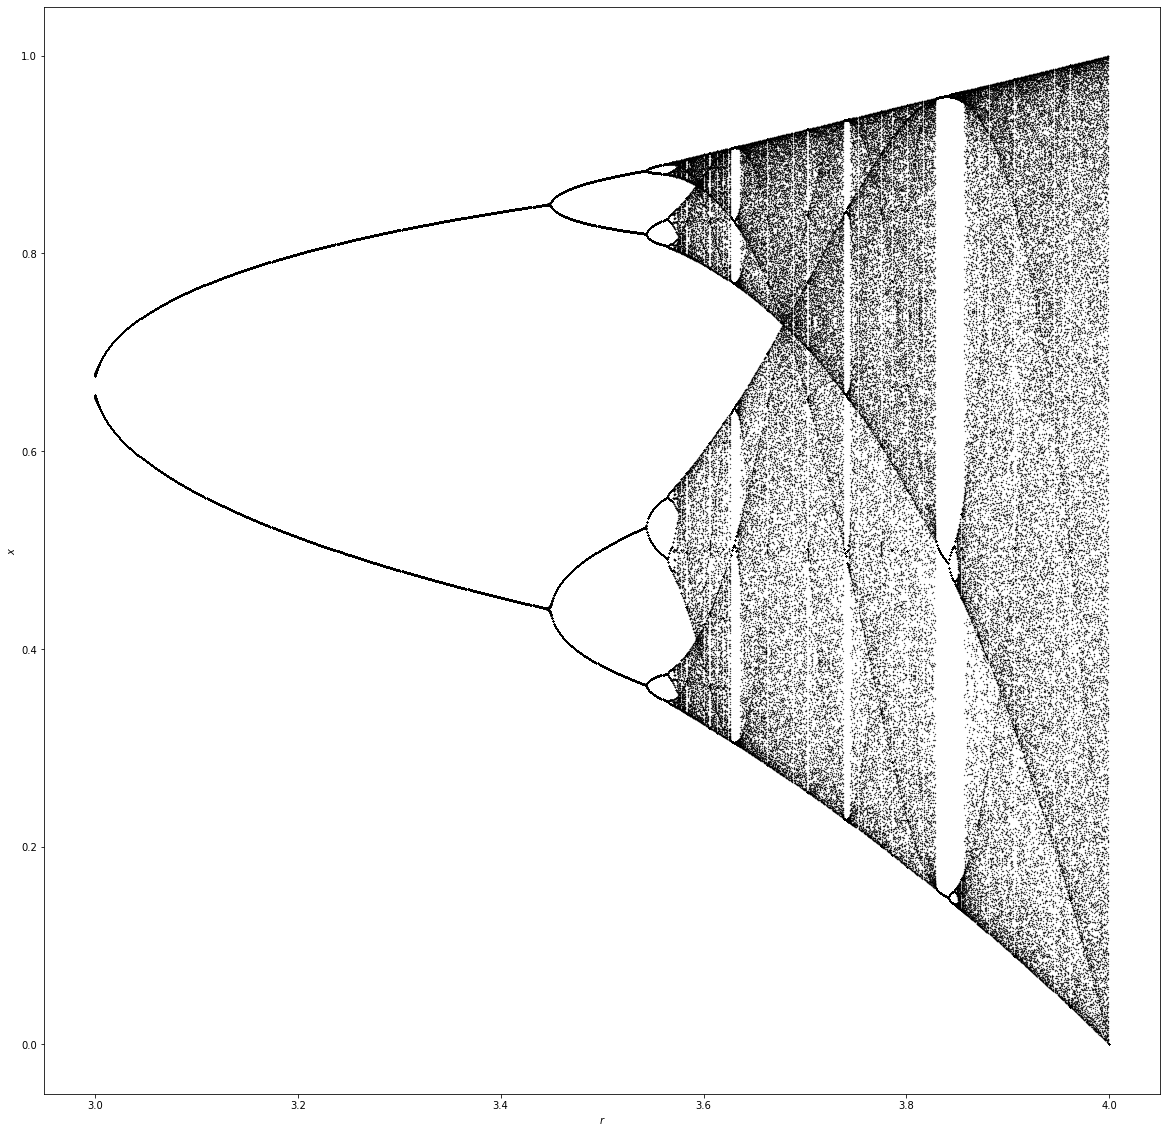

In [141]:
def logistic_map(r):
  return lambda x: r * x * (1 - x)

rs = np.linspace(3, 4, 1000)

for r in rs:
  # Remove the first 300 values to remove transient behaviour from the choice of initial point
  values = get_iterative_map_results(logistic_map(r), .5, 600)[300:]
  plt.scatter([r for _ in values], values, color="black", s=.1)

plt.ylabel("$x$")
plt.xlabel("$r$")
plt.show()

The 3-cycle periodicity at $r \approx 3.8284$ occurs through **intermittant periodicity**: just before this value of $r$ the points spend a lot of time caught near what become stable fixed points for $f^3(x)$ (i.e. stable 3-cycles) but slowly move away, eventually moving far enough away to exhibit chaotic behaviour, the trajectories then eventually come close to an (almost) stable fixed point again and get caught near it (this is also why there are darker lines in the chaotic regions of the orbit diagram). As $r$ approaches the value at which the periodic window occurs, the time spent near the (almost) stable fixed points increase, until eventually they become actual stable fixed points representing 3-cycles. The almost stable fixed points can be viewed as ghosts of the stable 3-cycles (which occur through saddle-node bifurcations)

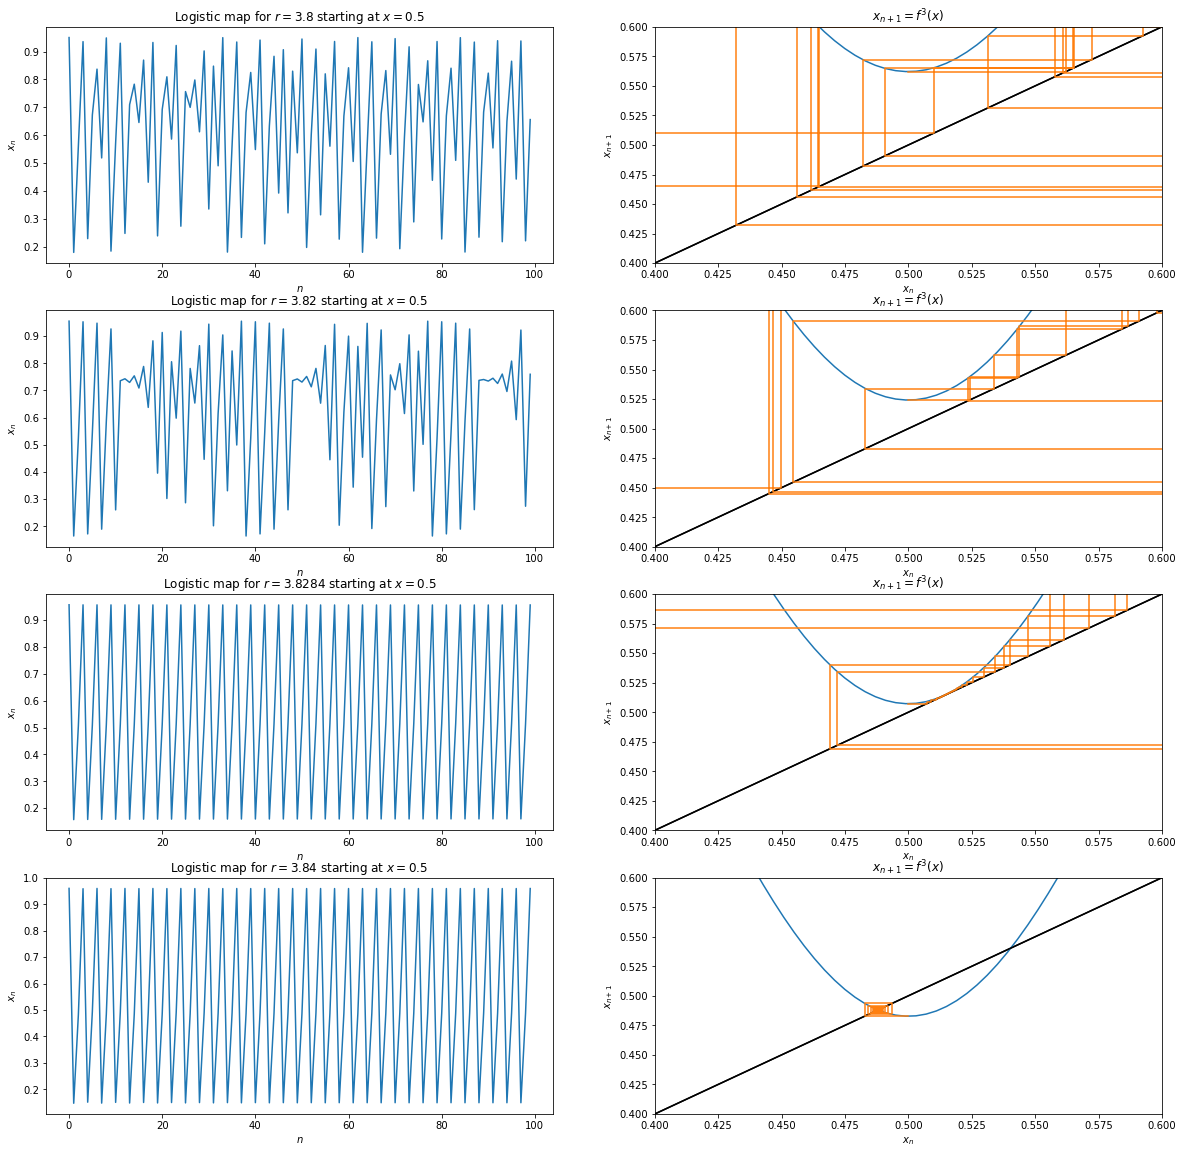

In [81]:
import functools

x = np.linspace(0, 1, 1000)

logistic_map_3 = lambda r: np.vectorize(lambda x: logistic_map)
def logistic_map_3(r):
  map = logistic_map(r)
  return np.vectorize(lambda x: map(map(map(x))))

for idx, r in enumerate([3.8, 3.82, 3.8284, 3.84]):
  plt.subplot(4, 2, idx * 2 + 1)
  x = get_iterative_map_results(logistic_map(r), .5, 100)
  n = [idx for idx, _ in enumerate(x)]
  plt.plot(n, x)
  plt.title(f"Logistic map for $r={r}$ starting at $x=0.5$")
  plt.xlabel("$n$")
  plt.ylabel("$x_n$")

  plt.subplot(4, 2, idx * 2 + 2)
  plt.plot([0, 1], [0, 1], color="black")
  plot_cobweb(logistic_map_3(r), [.5], 100)
  plt.xlim([0.4, .6])
  plt.ylim([0.4, .6])
  plt.title("$x_{n+1} = f^3(x)$")
  plt.ylabel("$x_{n+1}$")
  plt.xlabel("$x_n$")

Liapunov exponents can be defined for iterative maps in a similar way to how they are defined for continuous functions. Suppose a point starts at $x_0 + \delta_0$, let $f^n(x_0 + \delta_0) \equiv f^n(x_0) + \delta_n = x_n + \delta_n$, note that $f^n(x_0 + \delta_0) \approx x_n + (f^n)'(x_0) \delta_0$ thus $\delta_n \approx (f^n)'(x_0) \delta_0$. Suppose $\delta_n = e^{\lambda n} \delta_0$, then $\lambda \approx \frac{1}{n}\ln|(f^n)'(x_0)|$. Expanding with the chain rule gives $\lambda \approx \frac{1}{n}\sum_{i=1}^{n-1} \ln|f'(x_i)|$, if this series is convergent when $n \to \infty$ then $\lambda$ is the **Liapunov exponent**.

When the Liapunov exponent is less than zero, it results in trajectories that converge on certain values, for the Logistic map this can be used to determine when chaos occurs and when periodic windows occur

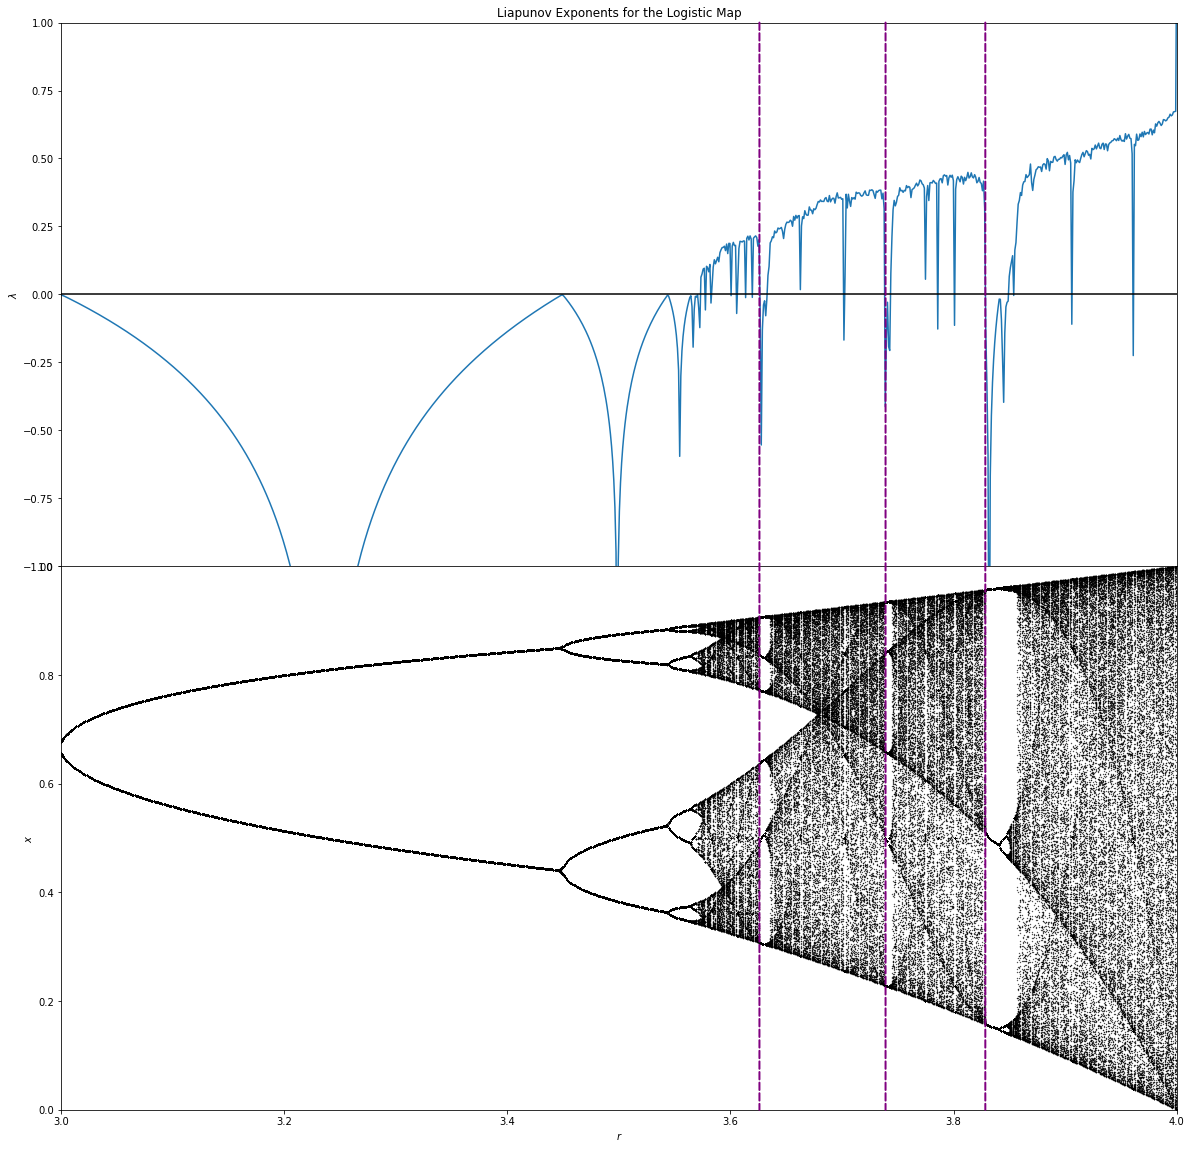

In [142]:
def d_logistic_map_dx(r):
  return lambda x: r - 2 * r * x

def get_liapunov_exponent(fn, dfn_dx, x_init, start_cutoff = 300, num_terms_to_calculate = 1300):
  x_curr = x_init
  exponent_acc = 0
  for i in range(num_terms_to_calculate):
    x_curr = fn(x_curr)
    if (i < start_cutoff):
      continue

    exponent_acc += np.log(np.abs(dfn_dx(x_curr)))

  return exponent_acc / (num_terms_to_calculate - start_cutoff)

fig, (axA, axB) = plt.subplots(nrows=2, sharex=True, gridspec_kw=dict(hspace=0))

axA.set_title("Liapunov Exponents for the Logistic Map")

# print(get_liapunov_exponent(logistic_map(3.4), d_logistic_map_dx(3.4), .5))
rs = np.linspace(3, 4, 1000)
liapunov_exponents = [get_liapunov_exponent(logistic_map(r), d_logistic_map_dx(r), 0.5) for r in rs]

axA.plot(rs, liapunov_exponents)
axA.axhline(color="black")
axA.set_xlim([3, 4])
axA.set_ylim([-1, 1])
axA.xaxis.set_visible(False)
axA.set_ylabel("$\lambda$")

for r in rs:
  # Remove the first 300 values to remove transient behaviour from the choice of initial point
  values = get_iterative_map_results(logistic_map(r), .5, 600)[300:]
  axB.scatter([r for _ in values], values, color="black", s=.1)

axB.set_xlim([3, 4])
axB.set_ylim([0, 1])
axB.set_xlabel("$r$")
axB.set_ylabel("$x$")

for r_periodic_window in [3.626, 3.739, 3.8284]:
  con = ConnectionPatch([r_periodic_window, 1], [r_periodic_window, 0], "data", axesA=axA, axesB=axB, color="purple", ls="dashed", lw=2)
  fig.add_artist(con)

## Feigenbaum's Renormalisation Theory

For any continuous unimodal function, the point $x_m$ at which the maxima of $f$ is a supercritical fixed point can be used to find all of the values for which cycles are superstable. For an n-cycle the multiplier of $f^n$ at a fixed point is the product of the multipliers of the points in the cycle (by the chain rule), thus for it to be supercritical one of the multipliers must be zero, for a unimodal function the only such multiplier occurs at $x_m$ thus $x_m$ must be a point in the n-cycle for it to be superstable. Drawing a horizontal line at $x_m$ and looking at the values of $r$ for which it intersects the orbit diagram gives the values $R_i$ at which the superstable cycles occur.

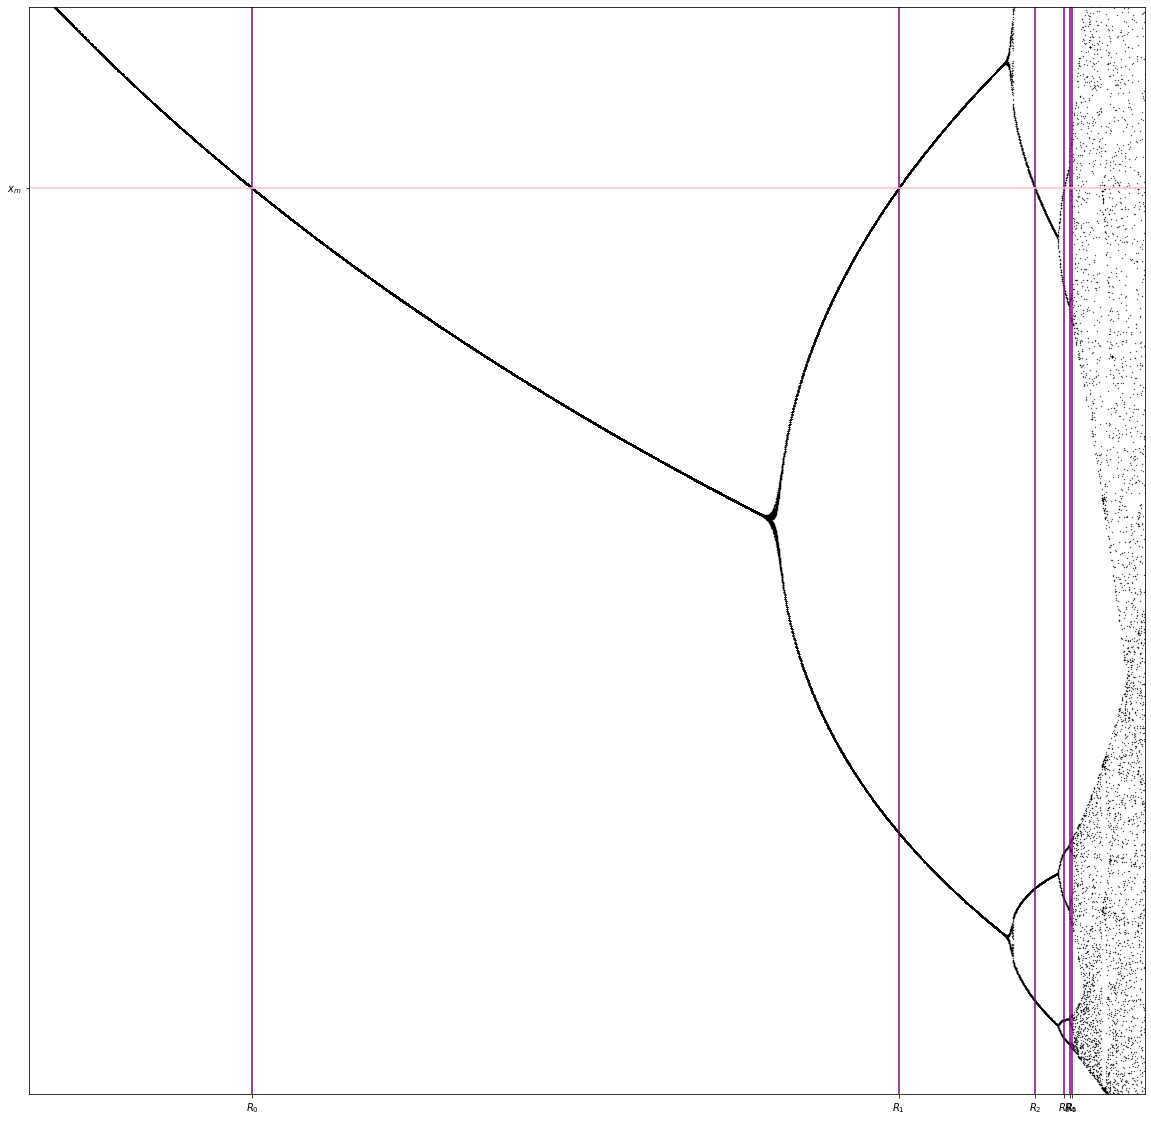

In [64]:
plt.figure(figsize=(20, 20))

def quadratic_map(r):
  return lambda x: r * (1 - x ** 2)

rs = np.linspace(.95, 1.2, 3000)

supercritical_points = []
prev_sign = 1
for r in rs:
  # Remove the first 300 values to remove transient behaviour from the choice of initial point
  values = get_iterative_map_results(quadratic_map(r), .5, 600)[300:]
  plt.scatter([r for _ in values[::10]], values[::10], color="black", s=.1)

  zero_value_sign = np.sign(values[np.argmin(np.abs(values))])
  if (zero_value_sign != prev_sign or zero_value_sign == 0) and len(supercritical_points) <= 5:
    plt.axvline(r, color="purple")
    supercritical_points.append(r)
  prev_sign = 1 if zero_value_sign >= 0 else -1

plt.axhline(0, color="pink")
plt.ylim([-.5, .1])
plt.xlim([.95, 1.2])
plt.yticks([0], ["$x_m$"])
plt.xticks(supercritical_points, [f"$R_{i}$" for i, _ in enumerate(supercritical_points)])
plt.show()

As $f^2$ is superstable at $x_m$ it must locally be the same shape as $f$ at $x_m$ (i.e. if $f$ is quadratic at $x_m$ then so is $f^2$) except scaled down. Scaling by a factor of $\alpha \approx -2.5029$ results in the neighbourhood of $f^2$ at $x_m$ becoming almost identical to that of $f$ at $x_m$. Repeating this shows that the orbit diagram is repeated infinitely for each $2^n$-cycle. Letting $n \to \infty$, Feigenbaum found numerically that this approaches a universal function $g_0$ which reflects the fact that all information about the global shape of the curve is lost (note that the shape of $g_0$ depends on the order of the polynomial curve at $x_m$ i.e. if the curve is quartic then $g_0$ will be different to if it is quadratic).

## Exercises

### 10.1.10
$x_{n+1} = 1 + \frac{1}{2}\sin x_n$
Has a unique fixed point which is stable

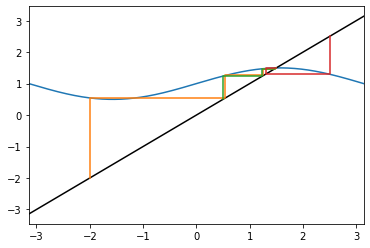

In [70]:
plot_cobweb(lambda x: 1 + np.sin(x)/2, [-2, .5, 2.5], 10, [-np.pi, np.pi])

### 10.1.11

$x_{n+1} = 3x_n - x_n^3$

(-3.0, 3.0)

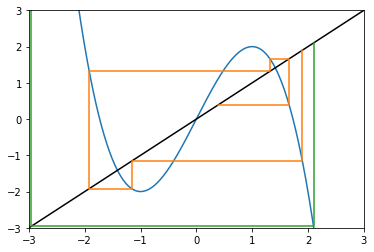

In [79]:
plot_cobweb(lambda x: 3 * x - x ** 3, [1.9, 2.1], 5, [-3, 3])
plt.ylim([-3, 3])

### 10.2.4 - 10.2.8

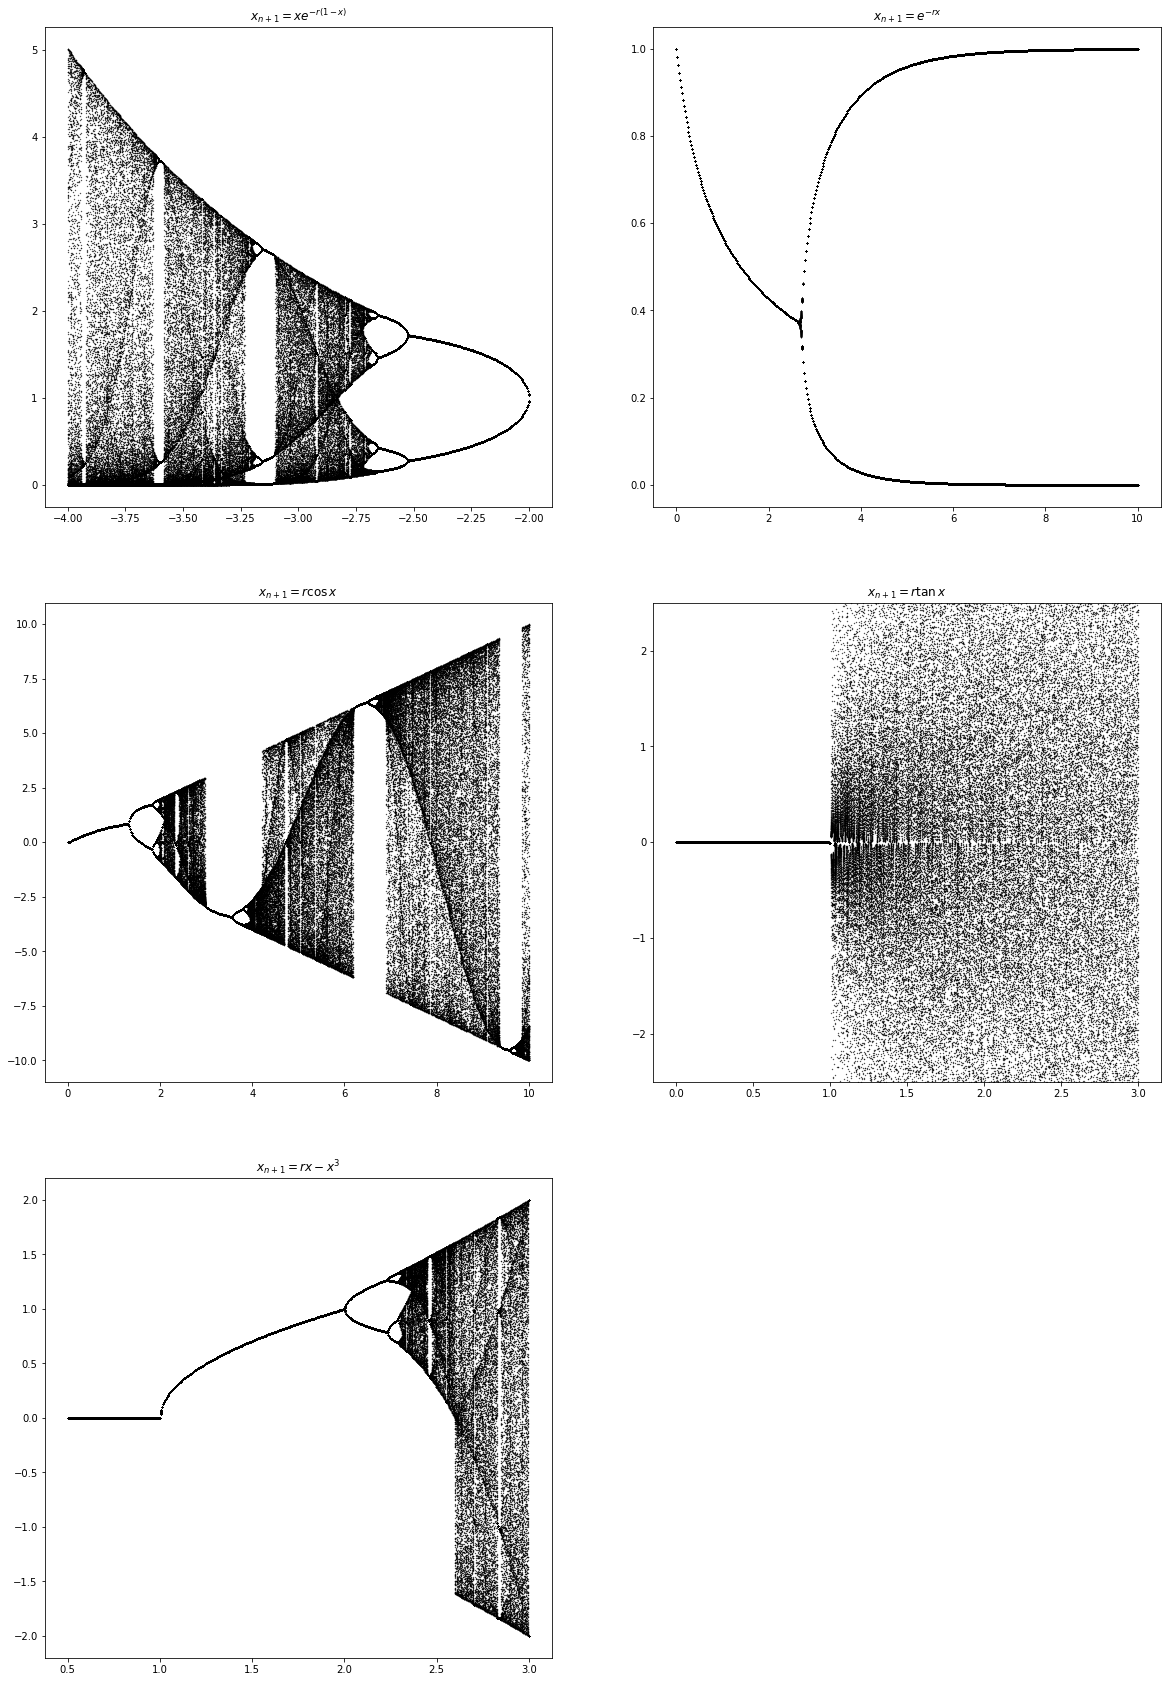

In [3]:
plt.figure(figsize=(20, 30))

plt.subplot(3, 2, 1)
plt.title("$x_{n+1} = xe^{-r(1-x)}$")
plot_orbit_diagram(lambda r: lambda x: x * np.exp(-r * (1-x)), r_range=[-4, -2], num_rs=500, num_iterations=600, init_val=.1)

plt.subplot(3, 2, 2)
plt.title("$x_{n+1} = e^{-rx}$")
plot_orbit_diagram(lambda r: lambda x: np.exp(-r * x), r_range=[0, 10], num_rs=500, num_iterations=600, init_val=.5)

plt.subplot(3, 2, 3)
plt.title("$x_{n+1} = r\cos x$")
plot_orbit_diagram(lambda r: lambda x: r * np.cos(x), r_range=[0, 10], num_rs=500, num_iterations=600, init_val=-1)

plt.subplot(3, 2, 4)
plt.title("$x_{n+1} = r\\tan x$")
plot_orbit_diagram(lambda r: lambda x: r * np.tan(x), r_range=[0, 3], num_rs=500, num_iterations=600, init_val=-1)
plt.ylim([-2.5, 2.5])

plt.subplot(3, 2, 5)
plt.title("$x_{n+1} = rx - x^3$")
plot_orbit_diagram(lambda r: lambda x: r * x - x**3, r_range=[.5, 3], num_rs=500, num_iterations=600, init_val=1)

### 10.5.6
Liapunov exponent for $x_{n+1} = r\sin\pi x_n$ with $x_n, r \in [0, 1]$

/var/folders/hb/ndq4xgw56y777czh0sk97vcw0000gn/T/ipykernel_30439/2064457490.py:12: RuntimeWarning: divide by zero encountered in log
  exponent_acc += np.log(np.abs(dfn_dx(x_curr)))


<function matplotlib.pyplot.show(close=None, block=None)>

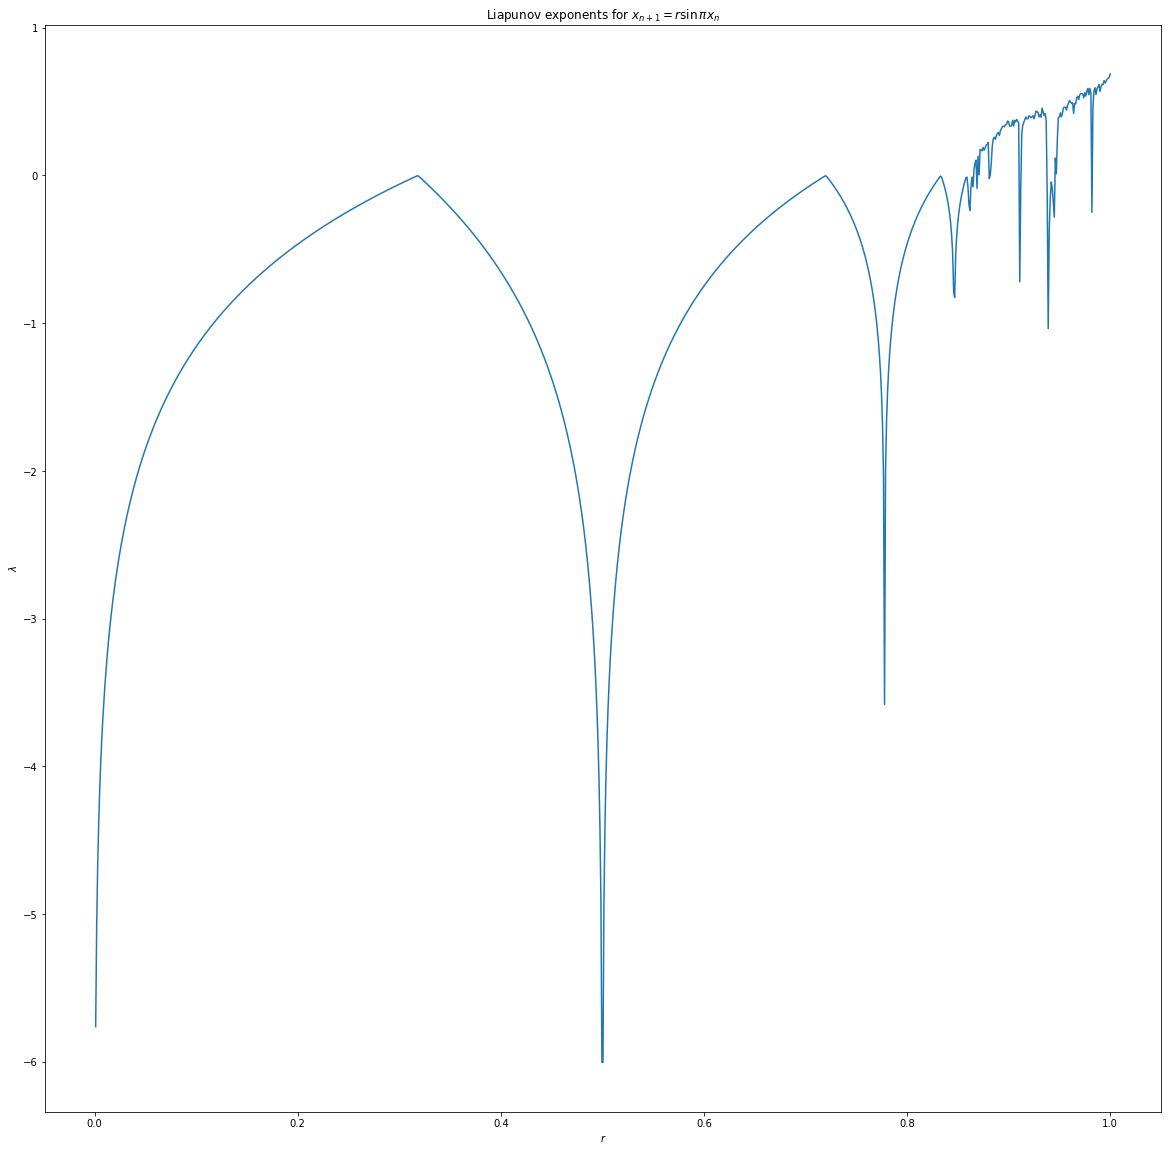

In [146]:
def sine_map(r):
  return lambda x: r * np.sin(np.pi * x)

def d_sine_map_dx(r):
  return lambda x: np.pi * r * np.cos(np.pi * x)

rs = np.linspace(0, 1, 1000)
liapunov_exponents = [
  get_liapunov_exponent(sine_map(r), d_sine_map_dx(r), .5)
  for r in rs
]

plt.plot(rs, liapunov_exponents)
plt.title("Liapunov exponents for $x_{n+1} = r\sin\pi x_n$")
plt.xlabel("$r$")
plt.ylabel("$\lambda$")
plt.show

### 10.6.1

The bifurcation points of the sine map can be found by iteratively finding the number of points in the cycle and decreasing/increasing $r$ depending on the number. Decreasing when the number of points is greater than or equal to those in the desired cycle and increasing when it is less, and constantly decreasing the delta value, results in a series that converges on the bifurcation point. Note that this relies on the fact that no $n-cycle$ occurs later in the orbit diagram. Starting with $r = .5$ and $\delta = .25$ allows for converging on any number in the interval $(0, 1)$ which is the codomain of the sine map.

In [307]:
iteration_count = 100_000

bifurcation_points = []

for n in range(1, 7):
  prev_r = 0
  r = .5
  delta = .25
  num_points = 1
  while round(r, 5) != round(prev_r, 5):
    values = get_iterative_map_results(sine_map(r), .5, iteration_count)[iteration_count-300:]
    num_points = len(np.unique([int(v * 1e6) for v in values]))
    prev_r = r
    if num_points >= 2**n:
      r -= delta
    else:
      r += delta
    delta /= 2

  bifurcation_points.append(round(r, 5))
  
for n, r in enumerate(bifurcation_points, start=1):
  print(f"r_{n} = {r}")

feigenbaum_ratio = ((np.array(bifurcation_points) - np.roll(bifurcation_points, 1)) / (np.roll(bifurcation_points, -1) - np.array(bifurcation_points)))[1:-1]
print("Feigenbaum ratio estimates: ", feigenbaum_ratio)

r_1 = 0.71994
r_2 = 0.83326
r_3 = 0.8586
r_4 = 0.86408
r_5 = 0.86526
r_6 = 0.86552
Feigenbaum ratio estimates:  [4.47198106 4.62408759 4.6440678  4.53846154]


### 10.6.2

In [357]:
x_m = .5

iteration_count = 1_000

bifurcation_points = []

n = 1
rs = np.linspace(0, 1, 10_000)
values = [get_iterative_map_results(sine_map(r), .5, iteration_count)[iteration_count-300:] for r in rs]

closest_vals_to_x_m = [vs[np.argmin(np.abs(np.array(vs) - x_m))] for vs in values]
dist_from_x_m = np.array(closest_vals_to_x_m) - x_m
Rs = np.extract(np.sign(dist_from_x_m) != np.sign(np.roll(dist_from_x_m, -1)), rs)[:6]
  
print("Rs", Rs)
feigenbaum_ratio = ((np.array(Rs) - np.roll(Rs, 1)) / (np.roll(Rs, -1) - np.array(Rs)))[1:-1]
print("Feigenbaum ratio estimates: ", feigenbaum_ratio)

Rs [0.49994999 0.77767777 0.84628463 0.86138614 0.86468647 0.86538654]
Feigenbaum ratio estimates:  [4.04810496 4.54304636 4.57575758 4.71428571]
